In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
import wrds

from dotenv import dotenv_values
config = dotenv_values(".env")

from mylib.load_from_wrds import query_options_stock, query_zero_curve
from mylib.rates_tools import create_yield_curve, merge_interest
from mylib.construct_tracer import construct_tracer
from mylib.BS_formulas import bs_delta, bs_IV
from mylib.regression import regression_rolling

%load_ext autoreload
%autoreload 2

In [2]:
secid = 113993
name = "GameStop"
ticker = "GME"

# secid = 189943
# name = "AMC Theatres"
# ticker = "AMC"

startdate = '2019-01-01'
enddate = '2023-12-31'

ALLOWED_ADJ_FACTOR_CHANGE = [0.99, 1.01]    #to filter options where adjustment factor changes over lifetime

# Download data from WRDS and do some preliminary cleaning

In [3]:
%%time

db = wrds.Connection(wrds_username=config['WRDS_USER'])

df_option = query_options_stock(db, secid, startdate=startdate, enddate=enddate)
zero_curve = query_zero_curve(db, startdate=startdate, enddate=enddate)

db.close()

Loading library list...
Done
CPU times: user 6.1 s, sys: 1.14 s, total: 7.24 s
Wall time: 18.4 s


In [3]:
# can be deleted later
df_option = pd.read_csv("../data/raw/WRDS/df_option_113993.csv", parse_dates = ['date', 'exdate'])
zero_curve = pd.read_csv("../data/raw/WRDS/zero_curve.csv", parse_dates = ['date'])
# 
print(df_option.shape)
df_option.sample(3)

(1228842, 20)


,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest
209484,113993.0,136450516.0,2020-10-19,2020-11-20,C,1.628698,0.211534,51.0,933.0,100.0,32,0.088889,5.75,0.16250,3.4775,11.907896,0.25,11.907896,0.604783,293625.0
494731,113993.0,140137350.0,2021-05-13,2021-06-25,C,1.301985,0.909446,5.0,6.0,100.0,43,0.119444,25.00,17.06875,41.1250,11.907896,0.25,11.907896,1.645000,259943.0
69828,113993.0,127439296.0,2019-07-15,2019-07-19,C,NaN,NaN,0.0,0.0,100.0,4,0.011111,7.50,0.00375,1.1875,11.907896,0.25,11.907896,0.158333,152530.0


In [4]:
def filter_adj_factor_change(df, ALLOWED_ADJ_FACTOR_CHANGE=[0.99, 1.01]):
    adj_change = df['adj_fac_expiration'] / df['adj_fac0']
    bl = (ALLOWED_ADJ_FACTOR_CHANGE[0] > adj_change) | (adj_change > ALLOWED_ADJ_FACTOR_CHANGE[1])    
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) options that are removed due to a large change in adjustment factor.')
    
    return df[~bl]

In [5]:
df_option = filter_adj_factor_change(df_option, ALLOWED_ADJ_FACTOR_CHANGE)

There are 15266 (1.24%) options that are removed due to a large change in adjustment factor.


Add interest rates and underlying info to options dataframe:

In [6]:
df_option.loc[df_option['date'].isin(['2021-01-25']) & (abs(df_option['S0'] - df_option['K']) < 5), :].head(2)

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest
270040,113993.0,138096584.0,2021-01-25,2021-01-29,C,NaN,NaN,622.0,782.0,100.0,4,0.011111,14.25,6.6250,19.1975,11.907896,0.25,11.907896,1.347193,320534.0
270041,113993.0,138096585.0,2021-01-25,2021-01-29,C,NaN,NaN,855.0,1263.0,100.0,4,0.011111,14.50,6.5375,19.1975,11.907896,0.25,11.907896,1.323966,320534.0


In [7]:
%%time

df_rate = create_yield_curve(zero_curve, max_days=1500) 
df = merge_interest(df_option, df_rate)

CPU times: user 2.21 s, sys: 1.73 s, total: 3.94 s
Wall time: 4.01 s


In [8]:
df.loc[df['date'].isin(['2021-01-25']) & (abs(df['S0'] - df['K']) < 5), :].head(2)

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r
254774,113993.0,138096584.0,2021-01-25,2021-01-29,C,NaN,NaN,622.0,782.0,100.0,4,0.011111,14.25,6.6250,19.1975,11.907896,0.25,11.907896,1.347193,320534.0,0.000982,0.000982
254775,113993.0,138096585.0,2021-01-25,2021-01-29,C,NaN,NaN,855.0,1263.0,100.0,4,0.011111,14.50,6.5375,19.1975,11.907896,0.25,11.907896,1.323966,320534.0,0.000982,0.000982


In [9]:
def add_next_observation(df):
    # adding future values to dataframe
    grouped = df.groupby('optionid')
    df['S1'] = grouped['S0'].shift(-1)
    df['r1'] = grouped['r'].shift(-1)
    df['IV1'] = grouped['IV0'].shift(-1)
    df['tau1'] = grouped['tau'].shift(-1)
    df['V1'] = grouped['V0'].shift(-1)
    return df

In [10]:
df = add_next_observation(df)

In [11]:
def filter_data_pre_tracer(df):
    orig_size = len(df)
    #-----------------------------------------
    # Filter by missing price data
    #-----------------------------------------
    bl = df['S0'].isnull() | df['V0'].isnull() | df['S1'].isnull() | df['V1'].isnull()
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due missing price data.')   
    #these are options with zero days to maturity or at the enddate
    df = df.loc[~bl]

    #-----------------------------------------
    # Filter by open_interest
    #-----------------------------------------
    bl = df['open_interest'].eq(0)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed because of zero interest.')   
    #these are options with zero days to maturity or at the enddate
    df = df.loc[~bl]

    #----------------------
    #  filter by volume and open interest
    #----------------------    
    CUTOFF_DAILY_INTEREST = 0.01
    bl = df['volume'].eq(0) & df['open_interest'].div(df['open_total_interest']).lt(CUTOFF_DAILY_INTEREST)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due no volume and small open interest.')
    df = df[~bl]

    n_removed = orig_size - len(df)
    print(f'Removed in total: {n_removed} ({n_removed/orig_size*100:.2f}%) of all options. New data size: {len(df)}.') 
    return df

In [12]:
df = filter_data_pre_tracer(df)

There are 29798 (2.46%) option days that are removed due missing price data.
There are 248331 (20.98%) option days that are removed because of zero interest.
There are 403209 (43.10%) option days that are removed due no volume and small open interest.
Removed in total: 681338 (56.14%) of all options. New data size: 532238.


# Construct tracer options and calculate implied dividends

In [13]:
%%time
df_tracer = pd.DataFrame()
for target_tau_days in [10, 20, 30, 45, 60, 75, 90, 120, 150, 180, 210]:
    for cp_flag in ['C', 'P']:
        df_tmp = construct_tracer(df, df_rate, cp_flag, target_tau_days, ALLOWED_ADJ_FACTOR_CHANGE)
        df_tracer = pd.concat([df_tracer, df_tmp])

CPU times: user 1min, sys: 2.1 s, total: 1min 2s
Wall time: 1min 37s


# Explore (can be deleted later)

In [14]:
df_tracer.loc[df_tracer['date'] == '2021-01-25']

,date,S0,S1,IV0,K,cp_flag,tau_days,tau,short_rate,r,V0,V0_interpolated,V1,V1_interpolated,normDelta


In [15]:
df_tracer.loc[df_tracer['date'] == '2021-01-27']

,date,S0,S1,IV0,K,cp_flag,tau_days,tau,short_rate,r,V0,V0_interpolated,V1,V1_interpolated,normDelta


In [16]:
df_tracer.loc[df_tracer['date'] == '2021-01-26']

,date,S0,S1,IV0,K,cp_flag,tau_days,tau,short_rate,r,V0,V0_interpolated,V1,V1_interpolated,normDelta
495,2021-01-26,36.995,86.8775,4.945635,36.995,C,10,0.027778,0.000929,0.000968,11.829875,True,30.383575,True,0.659892
504,2021-01-26,36.995,86.8775,3.794188,36.995,P,10,0.027778,0.000929,0.000968,9.179167,True,8.841658,True,-0.375916
492,2021-01-26,36.995,86.8775,4.289210,36.995,C,20,0.055556,0.000929,0.001099,14.309769,True,18.502816,True,0.693413
500,2021-01-26,36.995,86.8775,3.476858,36.995,P,20,0.055556,0.000929,0.001099,11.763360,True,11.528515,True,-0.340967
478,2021-01-26,36.995,86.8775,3.432616,36.995,C,30,0.083333,0.000929,0.001274,14.049010,True,24.050147,True,0.689898
491,2021-01-26,36.995,86.8775,3.141325,36.995,P,30,0.083333,0.000929,0.001274,12.936254,True,12.772945,True,-0.325084
467,2021-01-26,36.995,86.8775,2.935403,36.995,C,45,0.125000,0.000929,0.001544,14.658725,True,27.118758,True,0.698153
471,2021-01-26,36.995,86.8775,2.716000,36.995,P,45,0.125000,0.000929,0.001544,13.641155,True,13.508801,True,-0.315498
466,2021-01-26,36.995,86.8775,2.622247,36.995,C,60,0.166667,0.000929,0.001631,15.079648,False,29.530250,True,0.703854
469,2021-01-26,36.995,86.8775,2.443451,36.995,P,60,0.166667,0.000929,0.001631,14.127240,True,14.021418,True,-0.308876


In [17]:
from mylib.BS_formulas import bs_price, bs_delta, bs_IV_vec
#needs to be called for each secid separately
cp_flag = 'C'
target_tau_days = 60
df_select = df[(df['cp_flag'] == cp_flag) & (df['date'] == '2021-01-25')]

d_list = []
S0_list = []
IV_interp_list = []
IV1_list = []
S1_list = []
tau1_list = []
r1_list = []   
V0_interp_list = []
V1_interp_list = []

for d, dfg in df_select.groupby('date'):

    target_K = dfg.iloc[0]['S0']

    upper_left  = dfg[(dfg['tau_days'] <= target_tau_days) & (dfg['K'] >= target_K)] 
    upper_right = dfg[(dfg['tau_days'] >= target_tau_days) & (dfg['K'] >= target_K)] 
    lower_left  = dfg[(dfg['tau_days'] <= target_tau_days) & (dfg['K'] <= target_K)] 
    lower_right = dfg[(dfg['tau_days'] >= target_tau_days) & (dfg['K'] <= target_K)] 


    if upper_left.empty | upper_right.empty | lower_left.empty | lower_right.empty:
        continue

In [18]:
upper_left

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r,S1,r1,IV1,tau1,V1


In [19]:
upper_right

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r,S1,r1,IV1,tau1,V1


In [20]:
target_K

19.1975

In [21]:
dfg[(dfg['tau_days'] <= target_tau_days)]['K'].max()

18.75

In [22]:
dfg[(dfg['tau_days'] <= target_tau_days)]

,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,splitfactor,adj_fac_expiration,M0,open_total_interest,short_rate,r,S1,r1,IV1,tau1,V1
254698,113993.0,137628702.0,2021-01-25,2021-01-29,C,NaN,NaN,80.0,4.0,100.0,4,0.011111,0.125,19.11875,19.1975,11.907896,0.25,11.907896,153.580000,320534.0,0.000982,0.000982,36.995,0.000929,NaN,0.008333,35.85000
254699,113993.0,137628692.0,2021-01-25,2021-01-29,C,NaN,NaN,55.0,1.0,100.0,4,0.011111,0.250,18.99375,19.1975,11.907896,0.25,11.907896,76.790000,320534.0,0.000982,0.000982,36.995,0.000929,NaN,0.008333,35.69375
254700,113993.0,137628693.0,2021-01-25,2021-01-29,C,NaN,NaN,2.0,2.0,100.0,4,0.011111,0.375,18.75625,19.1975,11.907896,0.25,11.907896,51.193333,320534.0,0.000982,0.000982,36.995,0.000929,NaN,0.008333,35.50625
254701,113993.0,137628694.0,2021-01-25,2021-01-29,C,NaN,NaN,16.0,32.0,100.0,4,0.011111,0.500,18.63125,19.1975,11.907896,0.25,11.907896,38.395000,320534.0,0.000982,0.000982,36.995,0.000929,NaN,0.008333,35.38125
254702,113993.0,137628695.0,2021-01-25,2021-01-29,C,NaN,NaN,2.0,3.0,100.0,4,0.011111,0.625,18.50625,19.1975,11.907896,0.25,11.907896,30.716000,320534.0,0.000982,0.000982,36.995,0.000929,NaN,0.008333,35.25625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255974,113993.0,137959406.0,2021-01-25,2021-03-19,C,2.581776,0.796984,733.0,1069.0,100.0,53,0.147222,13.750,9.26250,19.1975,11.907896,0.25,11.907896,1.396182,320534.0,0.000982,0.001627,36.995,0.001609,1.414319,0.144444,23.39375
255975,113993.0,138096653.0,2021-01-25,2021-03-19,C,2.608196,0.771863,3632.0,4332.0,100.0,53,0.147222,15.000,8.79375,19.1975,11.907896,0.25,11.907896,1.279833,320534.0,0.000982,0.001627,36.995,0.001609,1.739594,0.144444,22.57500
255976,113993.0,138215426.0,2021-01-25,2021-03-19,C,2.640862,0.748142,121.0,4.0,100.0,53,0.147222,16.250,8.38750,19.1975,11.907896,0.25,11.907896,1.181385,320534.0,0.000982,0.001627,36.995,0.001609,2.066076,0.144444,22.11250
255977,113993.0,138215427.0,2021-01-25,2021-03-19,C,2.642869,0.724207,299.0,1.0,100.0,53,0.147222,17.500,7.95000,19.1975,11.907896,0.25,11.907896,1.097000,320534.0,0.000982,0.001627,36.995,0.001609,2.192291,0.144444,21.48750


In [23]:
def calc_implied_div(df_tracer):
    df_c = df_tracer[(df_tracer['cp_flag'] == 'C')]
    df_p = df_tracer[(df_tracer['cp_flag'] == 'P')]
    df = df_c.merge(df_p, on=['date', 'K', 'tau_days'], suffixes=[None, '_P'])
    df['impl_div'] = np.maximum(-1/df['tau'] * np.log((df['V0'] - df['V0_P'])/df['K'] + np.exp(-df['r'] * df['tau'])), 0)    
    return df[['date', 'tau_days', 'impl_div']]

In [24]:
## calculate implied dividend
df_impl_div = calc_implied_div(df_tracer)
df_impl_div.tail()

,date,tau_days,impl_div
10092,2022-06-17,210,0.204711
10093,2022-06-21,210,0.187433
10094,2022-06-22,210,0.205549
10095,2022-06-23,210,0.210330
10096,2022-06-24,210,0.445676


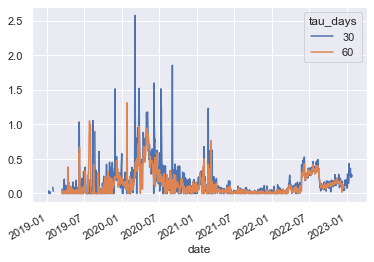

In [25]:
df_impl_div.pivot(index='date', columns='tau_days')['impl_div'][[30, 60]].plot();

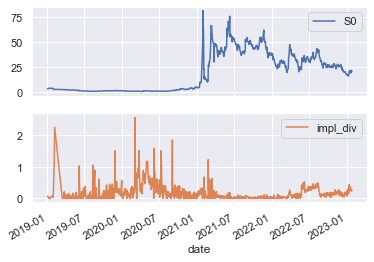

In [26]:
df[['date', 'S0']].drop_duplicates().merge(df_impl_div[df_impl_div['tau_days']==30][['date', 'impl_div']], 
                                           on='date').set_index('date', drop=True).plot(subplots=True);

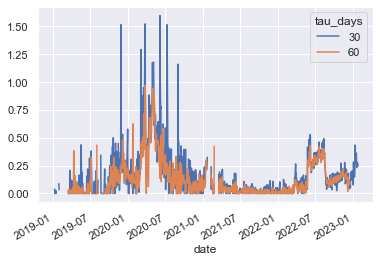

In [15]:
# df_impl_div.pivot(index='date', columns='tau_days')['impl_div'][[30, 60]].plot();

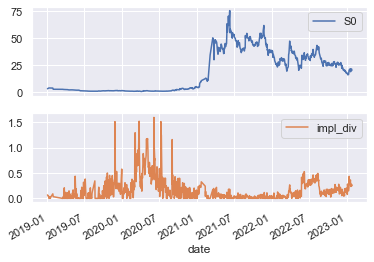

In [16]:
# df[['date', 'S0']].drop_duplicates().merge(df_impl_div[df_impl_div['tau_days']==30][['date', 'impl_div']], 
#                                            on='date').set_index('date', drop=True).plot(subplots=True);

In [27]:
df_tracer = pd.merge(df_tracer, df_impl_div, how='left', on=['date', 'tau_days'])
df_tracer['adjDelta'] = bs_delta(
    df_tracer['IV0'], df_tracer['K'], df_tracer['K'], df_tracer['tau'], df_tracer['r'], df_tracer['impl_div'], df_tracer['cp_flag'])

# Filter data

In [28]:
def filter_data_post_tracer(df):
    orig_size = len(df)

    #---------------------------------
    # Keep out-of-the-money options only
    #---------------------------------
    bl = (df['cp_flag'].eq('C') & df['M0'].gt(1.001)) | (df['cp_flag'].eq('P') & df['M0'].lt(0.999))
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due being in-the-money.')
    df = df.loc[~bl]


    #---------------------------------
    # Remove far out-of-the-money options
    #---------------------------------
    bl = ((df['cp_flag'] == 'C') & (df['M0'] < 0.8)) | ((df['cp_flag'] == 'P') & (df['M0'] > 1.25))
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed because they are too far out of-the-money.')
    df = df.loc[~bl]
    

    #--------------------
    # Filter by Maturity, part I
    #--------------------
    bl = df['tau_days'].le(7)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due being too close to expiry.')
    df = df[~bl]


    #--------------------
    # Filter by Maturity, part II
    #--------------------
    bl = df['tau'].gt(1)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due to time to expiry larger than 1 year.')
    df = df[~bl]
    
    
    #----------------------------------------------------
    #  filter all the options with negative time value
    #----------------------------------------------------
    bl_c = (df['cp_flag'] == 'C') & (df['S0'] - np.exp(-df['r'] * df['tau']) * df['K'] >= df['V0'])
    bl_p = (df['cp_flag'] == 'P') & (np.exp(-df['r'] * df['tau']) * df['K'] - df['S0'] >= df['V0'])
    bl = bl_c | bl_p
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due negative time value.')   
    df = df.loc[~bl]
 
    
    n_removed = orig_size - len(df)
    print(f'Removed in total: {n_removed} ({n_removed/orig_size*100:.2f}%) of all options. New data size: {len(df)}.') 
    return df

In [29]:
df = filter_data_post_tracer(df)

There are 159291 (29.93%) option days that are removed due being in-the-money.
There are 267744 (71.79%) option days that are removed because they are too far out of-the-money.
There are 19247 (18.30%) option days that are removed due being too close to expiry.
There are 2461 (2.86%) option days that are removed due to time to expiry larger than 1 year.
There are 0 (0.00%) option days that are removed due negative time value.
Removed in total: 448743 (84.31%) of all options. New data size: 83495.


# Fill in implied vols and compute deltas

In [81]:
%%time
## fill in implied vols
# df['IV0_is_inputed'] = df['IV0'].isna()
# df.loc[df['IV0'].isna(), 'IV0'] = df.loc[df['IV0'].isna(), :].apply(lambda x:bs_IV(**x), axis=1)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [31]:
## merge implied dividends with options df
df_impl_div_wide = df_impl_div.pivot(index='date', columns='tau_days')['impl_div'].ffill(axis=1).bfill(axis=1)
df_impl_div_wide[1] = df_impl_div_wide[min(df_impl_div_wide.columns)]
max_tau_days = df['tau_days'].max()
df_impl_div_wide[max_tau_days] = df_impl_div_wide[max(df_impl_div_wide.columns)]
tmp_df = pd.DataFrame(
    np.nan, columns=list(set(np.arange(2, max_tau_days)).difference(df_impl_div_wide.columns)), index=df_impl_div_wide.index)
df_impl_div_wide = pd.concat([df_impl_div_wide, tmp_df], axis=1)
df_impl_div_wide = df_impl_div_wide.reindex(sorted(df_impl_div_wide.columns), axis=1)
df_impl_div_wide = df_impl_div_wide.interpolate(axis=1).reset_index()
df_impl_div_narrow = pd.melt(df_impl_div_wide, id_vars='date', var_name='tau_days', value_name='impl_div')
df = pd.merge(df, df_impl_div_narrow, on=['date', 'tau_days'], how='left')

In [32]:
df['normDelta'] = bs_delta(df['IV0'], df['S0'], df['K'], df['tau'], df['r'], 0, df['cp_flag'])
df['delta_is_inputed'] = df['delta'].isna()
df.loc[df['delta'].isna(), 'delta'] = df.loc[df['delta'].isna(), 'normDelta'] 
df['adjDelta'] = bs_delta(df['IV0'], df['S0'], df['K'], df['tau'], df['r'], df['impl_div'], df['cp_flag'])

#### Delta-Delta plots on raw data

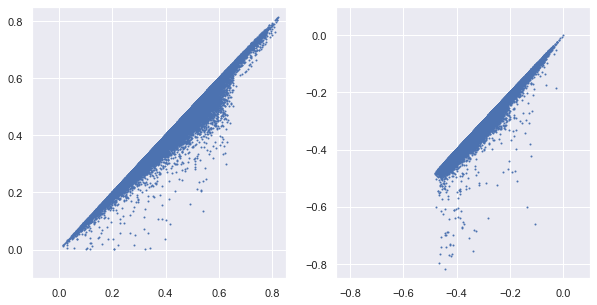

In [33]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))         
axs[0].scatter(df.loc[df['cp_flag'] == 'C', 'normDelta'], df.loc[df['cp_flag'] == 'C', 'adjDelta'], s=1)
axs[0].set_ylim([-0.1, 0.85])
axs[0].set_xlim([-0.1, 0.85])
axs[1].scatter(df.loc[df['cp_flag'] == 'P', 'normDelta'], df.loc[df['cp_flag'] == 'P', 'adjDelta'], s=1)
axs[1].set_ylim([- 0.85, 0.1])
axs[1].set_xlim([- 0.85, 0.1]);

#### Delta-Delta plots on tracer data

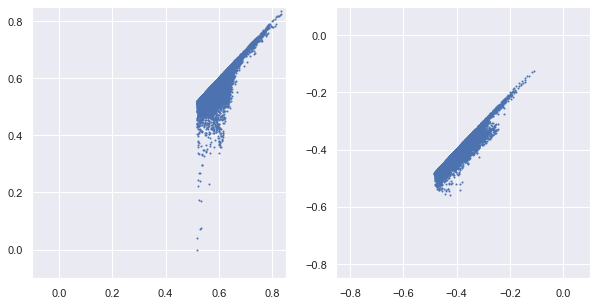

In [34]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))         
axs[0].scatter(df_tracer.loc[df_tracer['cp_flag'] == 'C', 'normDelta'], df_tracer.loc[df_tracer['cp_flag'] == 'C', 'adjDelta'], s=1)
axs[0].set_ylim([-0.1, 0.85])
axs[0].set_xlim([-0.1, 0.85])
axs[1].scatter(df_tracer.loc[df_tracer['cp_flag'] == 'P', 'normDelta'], df_tracer.loc[df_tracer['cp_flag'] == 'P', 'adjDelta'], s=1)
axs[1].set_ylim([- 0.85, 0.1])
axs[1].set_xlim([- 0.85, 0.1]);

# Regression

In [35]:
%%time

# instead of df, can also be used with df_tracer[df_tracer['V1'].notnull()]
dict_coef, dict_plot = regression_rolling(df, delta_type='normDelta', train_length=126, exp_weight=0.99)

Removed 2442 option days due to missing delta (normDelta).
CPU times: user 9.35 s, sys: 1.21 s, total: 10.6 s
Wall time: 9.1 s


In [36]:
def plot_scatter(dict_plot, date_in):
    dict = dict_plot[date_in]

    fig, axs = plt.subplots(1, 2, figsize=(18,9), sharey=True)
    axs[0].set_ylabel("Change of option price")

    for cp_flag, name, ax in zip(['C', 'P'], ['Call', 'Put'], axs):
        dict_tmp = dict[cp_flag]
        w = dict_tmp['w_train'] * 30
        ax.scatter(dict_tmp['x_train'], dict_tmp['y_train'], s=w)
        ax.plot(dict_tmp['x_train'], dict_tmp['coef'] * dict_tmp['x_train'], color='tab:orange')
        ax.scatter(dict_tmp['x_test'], dict_tmp['y_test'], color='tab:red')
        ax.annotate(f'{name} coefficient: ' + str(round(dict_tmp['coef'], 2)), 
                        xy=(0, 1), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points')
        ax.set_title(f'{name}: {date_in}')
        ax.set_xlabel(f"{dict_tmp['delta_type']} X Change of stock price")
    
    fig.tight_layout()   
    plt.close()
    return fig

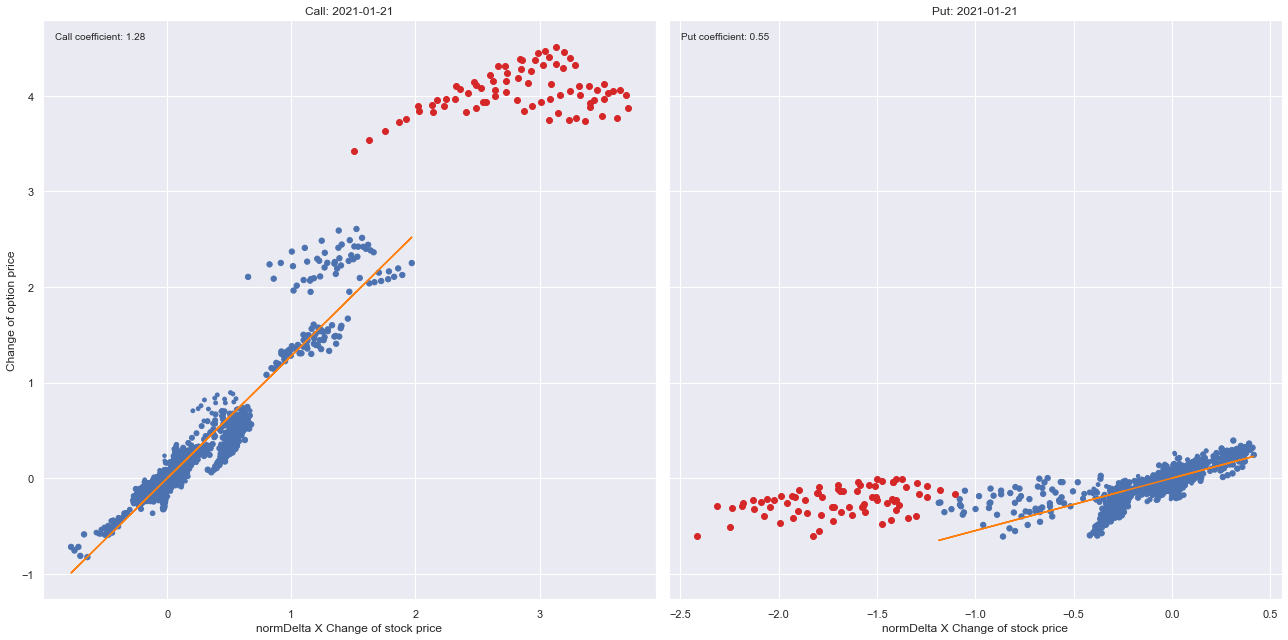

In [37]:
plot_scatter(dict_plot, '2021-01-21')

In [38]:
df_coef_ts = pd.DataFrame()
for key in dict_coef:
    df_coef_ts.loc[key, 'date'] = pd.to_datetime(key)
    df_coef_ts.loc[key, 'coef_C'] = dict_coef[key]['C']['coef']
    df_coef_ts.loc[key, 'N_train_C'] = dict_coef[key]['C']['N_train']
    df_coef_ts.loc[key, 'days_train_C'] = dict_coef[key]['C']['days_train']
    df_coef_ts.loc[key, 'N_test_C'] = dict_coef[key]['C']['N_test']

    df_coef_ts.loc[key, 'coef_P'] = dict_coef[key]['P']['coef']
    df_coef_ts.loc[key, 'N_train_P'] = -dict_coef[key]['P']['N_train']
    df_coef_ts.loc[key, 'days_train_P'] = dict_coef[key]['P']['days_train']
    df_coef_ts.loc[key, 'N_test_P'] = dict_coef[key]['P']['N_test']
    
df_coef_ts = df_coef_ts.sort_values(['date'])
df_coef_ts['coef_C_SMA10'] = df_coef_ts['coef_C'].rolling(10).mean()
df_coef_ts['coef_P_SMA10'] = df_coef_ts['coef_P'].rolling(10).mean()
df_coef_ts['N_train_C_SMA10'] = df_coef_ts['N_train_C'].rolling(10).mean()
df_coef_ts['N_train_P_SMA10'] = df_coef_ts['N_train_P'].rolling(10).mean()

tau_days = 30
df_syn_C = df_tracer.loc[(df_tracer['tau_days'] == tau_days) & (df_tracer['cp_flag'] == 'C'), ['date', 'V0', 'IV0', 'impl_div']].rename(columns = {'V0':'V0_C', 'IV0':'IV0_C'})
df_syn_P = df_tracer.loc[(df_tracer['tau_days'] == tau_days) & (df_tracer['cp_flag'] == 'P'), ['date', 'V0', 'IV0']].rename(columns = {'V0':'V0_P', 'IV0':'IV0_P'})
df_syn = pd.merge(df[['date', 'S0']].drop_duplicates(), df_syn_C, how='left', on=['date'])
df_syn = pd.merge(df_syn, df_syn_P, how='left', on=['date'])

df_coef_ts = df_syn.merge(df_coef_ts, how='left', on='date').sort_values(['date'])

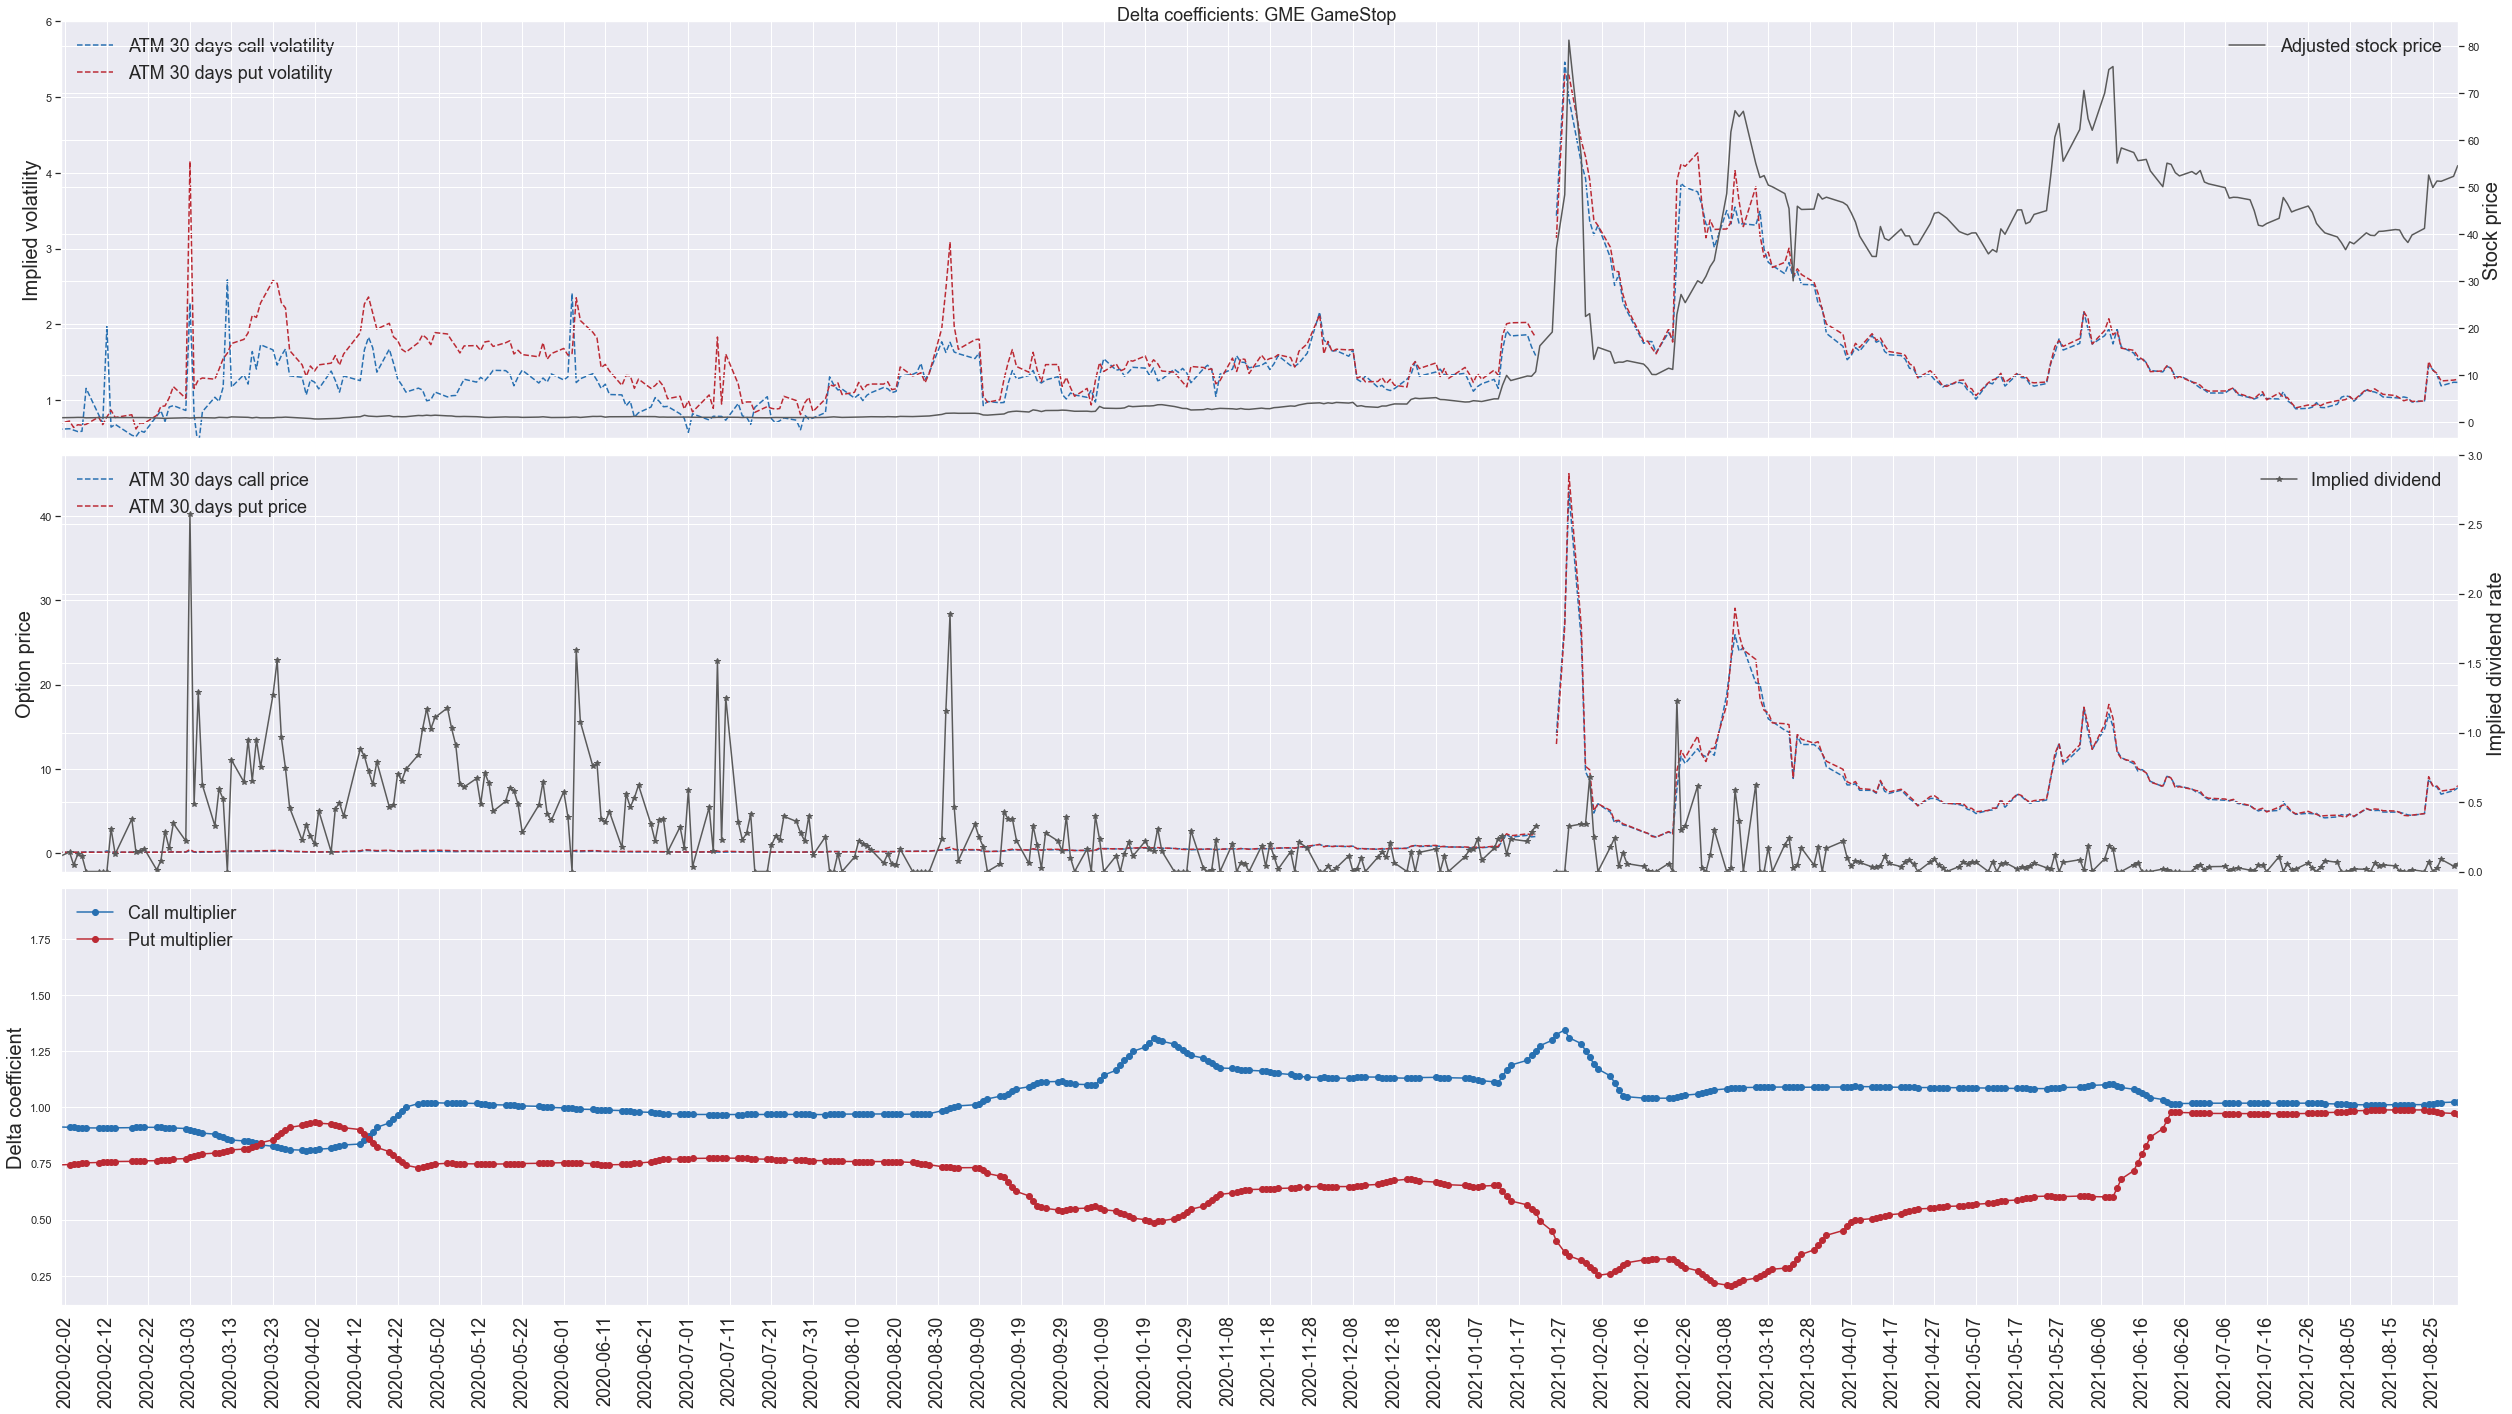

In [40]:
import matplotlib.dates as mdates


fig, axs = plt.subplots(3, 1, figsize=(35, 20), sharex=True)       

axs[0].plot(df_coef_ts['date'], df_coef_ts['IV0_C'], color=sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label=f'ATM {tau_days} days call volatility')
axs[0].plot(df_coef_ts['date'], df_coef_ts['IV0_P'], color=sns.color_palette("RdBu", n_colors=7)[0], linestyle='dashed', label=f'ATM {tau_days} days put volatility')
axs[0].set_ylabel("Implied volatility", fontsize=20) 
axs[0].set_ylim([0.5, 6]) 
axs[0].legend(loc=2, frameon=False, fontsize=18)  
ax0 = axs[0].twinx()
ax0.plot(df_coef_ts['date'], df_coef_ts['S0'], color=sns.color_palette("RdGy", n_colors=7)[6], label='Adjusted stock price')
ax0.set_ylabel("Stock price", fontsize=20)
ax0.legend(loc=1, frameon=False, fontsize=18)

axs[1].plot(df_coef_ts['date'], df_coef_ts['V0_C'], color=sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label=f'ATM {tau_days} days call price')
axs[1].plot(df_coef_ts['date'], df_coef_ts['V0_P'], color=sns.color_palette("RdBu", n_colors=7)[0], linestyle='dashed', label=f'ATM {tau_days} days put price')
axs[1].set_ylabel("Option price", fontsize=20)
axs[1].legend(loc=2, frameon=False, fontsize=18)
ax1 = axs[1].twinx()
ax1.plot(df_coef_ts['date'], df_coef_ts['impl_div'], color=sns.color_palette("RdGy", n_colors=7)[6], marker='*', label='Implied dividend')
ax1.set_ylabel("Implied dividend rate", fontsize=20)
ax1.set_ylim([0, 3]) 
ax1.legend(loc=1, frameon=False, fontsize=18)  

axs[2].plot(df_coef_ts['date'], df_coef_ts['coef_C_SMA10'], color=sns.color_palette("RdBu", n_colors=7)[6], marker='o', label='Call multiplier')
axs[2].plot(df_coef_ts['date'], df_coef_ts['coef_P_SMA10'], color=sns.color_palette("RdBu", n_colors=7)[0], marker='o', label='Put multiplier') 
axs[2].set_ylabel("Delta coefficient", fontsize=20)
axs[2].legend(loc=2, frameon=False, fontsize=18)
# ax2 = axs[2].twinx()
# ax2.plot(df_coef_ts['date'], df_coef_ts['N_train_C_SMA10'], color=sns.color_palette("RdBu", n_colors=7)[6], alpha=0.5, label="Call: number of training observations")
# ax2.plot(df_coef_ts['date'], df_coef_ts['N_train_P_SMA10'], color=sns.color_palette("RdBu", n_colors=7)[0], alpha=0.5, label="Put: number of training observations")
# ax2.set_ylabel("Number of observations in training", fontsize=20)  
# ax2.legend(loc=1, frameon=False) 
# max_tmp = max(df_coef_ts['N_train_C_SMA10'].max(), df_coef_ts['N_train_P_SMA10'].max())
# ax2.set_ylim(-max_tmp, max_tmp)

axs[2].xaxis.set_major_locator(mdates.DayLocator(interval=10))
axs[2].set_xlim([pd.to_datetime('2020-02-01'), pd.to_datetime('2021-08-31')])
plt.setp(axs[2].get_xticklabels(), rotation=90, fontsize=18)
fig.suptitle('Delta coefficients: ' + ticker + ' ' + name, fontsize=18)
fig.tight_layout()